# Single-cell RNA-seqs analysis using Python  
## Practicals 03: Batch correction and data integration

Adapted from:  
Single-cell best practices  
www.sc-best-practices.org

## 1.  Load dependencies
Activate the conda environment `sc_integration` to run this notebook.  
```
conda activate sc_integration
```

In [1]:
# package dependencies and suppress unnecessary warning messages 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

In [2]:
import scanpy as sc
import bbknn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
import harmonypy
import mnnpy

In [5]:
import os
os.getcwd()

'/home/training/scrnaseq_python_2023/practicals'

## 2.  Load and prepare input data

In [6]:
adata_raw = sc.read_h5ad(
    "/home/training/training_data/openproblems_bmmc_multiome_genes_filtered.h5ad"
)

In [7]:
adata_raw

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [8]:
# set raw counts as the main matrix
adata_raw.X = adata_raw.layers['counts']

In [9]:
adata_raw.obs.head(2)

,GEX_pct_counts_mt,GEX_n_counts,GEX_n_genes,GEX_size_factors,GEX_phase,ATAC_nCount_peaks,ATAC_atac_fragments,ATAC_reads_in_peaks_frac,ATAC_blacklist_fraction,ATAC_nucleosome_signal,cell_type,batch,ATAC_pseudotime_order,GEX_pseudotime_order,Samplename,Site,DonorNumber,Modality,VendorLot,DonorID,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker
TAGTTGTCACCCTCAC-1-s1d1,1.061008,1508.0,1022,0.453484,S,4031.0,5400,0.746481,0.003473,0.642468,Naive CD20+ B,s1d1,NaN,NaN,site1_donor1_multiome,site1,donor1,multiome,3054455,15078,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker
CTATGGCCATAACGGG-1-s1d1,0.604230,1655.0,1081,0.455631,G2M,8636.0,19266,0.448251,0.003126,1.220679,CD14+ Mono,s1d1,NaN,NaN,site1_donor1_multiome,site1,donor1,multiome,3054455,15078,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker


In [10]:
# set the cell type label key and batch key based on adata_raw.obs
label_key = "cell_type"
batch_key = "batch"

In [11]:
# check how many batches and hoe many observations within each batch

adata_raw.obs[batch_key].value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

In [12]:
keep_batches = ["s1d3", "s2d1", "s3d7"]
adata = adata_raw[adata_raw.obs[batch_key].isin(keep_batches)].copy()
adata

AnnData object with n_obs × n_vars = 10270 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [13]:
# Only keep gene expression features as the original data is a multiome dataset

adata.var["feature_types"].value_counts()

ATAC    116490
GEX      13431
Name: feature_types, dtype: int64

In [14]:
adata = adata[:, adata.var["feature_types"] == "GEX"].copy()
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## 3.  Data integration
### 1. First check unintegrated data

In [15]:
# standard analysis without considering batch

adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

In [16]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [17]:
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]  # Set custom colours for batches

In [18]:
matplotlib.rcParams['figure.figsize'] = [3, 6]

/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


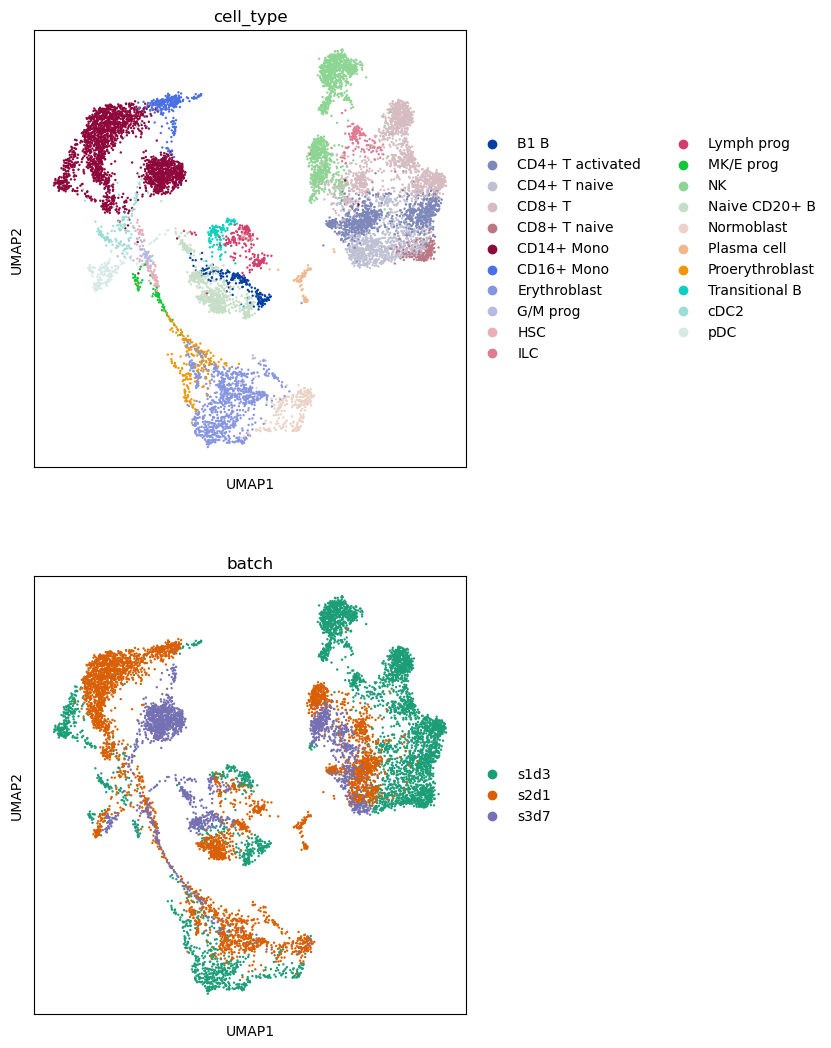

In [19]:
sc.pl.umap(adata, color=[label_key, batch_key], wspace=1, ncols=1)

### 2. Batch-aware feature selection

In [20]:
# add batch_key when selecting HVGs
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)

/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


In [21]:
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'c

In [22]:
# Note the highly_variable_nbatches and the highly_variable_intersection column
adata.var

,feature_types,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
AL627309.5,GEX,ENSG00000241860,112,False,0.006533,0.775289,0.357973,1,False
LINC01409,GEX,ENSG00000237491,422,False,0.024462,0.716935,-0.126119,0,False
LINC01128,GEX,ENSG00000228794,569,False,0.030714,0.709340,-0.296701,0,False
NOC2L,GEX,ENSG00000188976,675,False,0.037059,0.704363,-0.494025,0,False
KLHL17,GEX,ENSG00000187961,88,False,0.005295,0.721757,-0.028456,0,False
...,...,...,...,...,...,...,...,...,...
MT-ND5,GEX,ENSG00000198786,4056,False,0.269375,0.645837,-0.457491,0,False
MT-ND6,GEX,ENSG00000198695,1102,False,0.051506,0.697710,-0.248421,0,False
MT-CYB,GEX,ENSG00000198727,5647,False,0.520368,0.613233,-0.441362,0,False
AL592183.1,GEX,ENSG00000273748,732,False,0.047486,0.753417,0.413699,0,False


0    9931
1    1824
2     852
3     824
Name: highly_variable_nbatches, dtype: int64

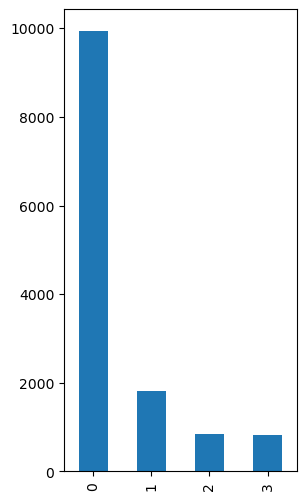

In [23]:
# see how many batches the gene is highly variable in

n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

### 3. example: integration with harmony

In [24]:
# move the unintegrated umap
adata.obsm['X_umapraw'] = adata.obsm['X_umap']

In [25]:
# run harmony via scanpy external API
sc.external.pp.harmony_integrate(adata, key=batch_key, basis = 'X_pca')

2023-09-13 15:04:56,453 - harmonypy - INFO - Iteration 1 of 10
2023-09-13 15:04:57,772 - harmonypy - INFO - Iteration 2 of 10
2023-09-13 15:04:59,132 - harmonypy - INFO - Iteration 3 of 10
2023-09-13 15:05:00,449 - harmonypy - INFO - Iteration 4 of 10
2023-09-13 15:05:01,773 - harmonypy - INFO - Iteration 5 of 10
2023-09-13 15:05:03,186 - harmonypy - INFO - Iteration 6 of 10
2023-09-13 15:05:03,939 - harmonypy - INFO - Converged after 6 iterations


In [27]:
# Note that a new embedding, which we named X_pca_harmony is generated
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap', 'X_umapraw', 'X_pca_harmony'


In [28]:
# recalculate neighbours and umap based on harmony corrected embedding

sc.pp.neighbors(adata, use_rep='X_pca_harmony', key_added = 'harmony', n_neighbors=15, n_pcs=40)
sc.tl.umap(adata, neighbors_key = 'harmony')

In [29]:
matplotlib.rcParams['figure.figsize'] = [5, 6]

/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


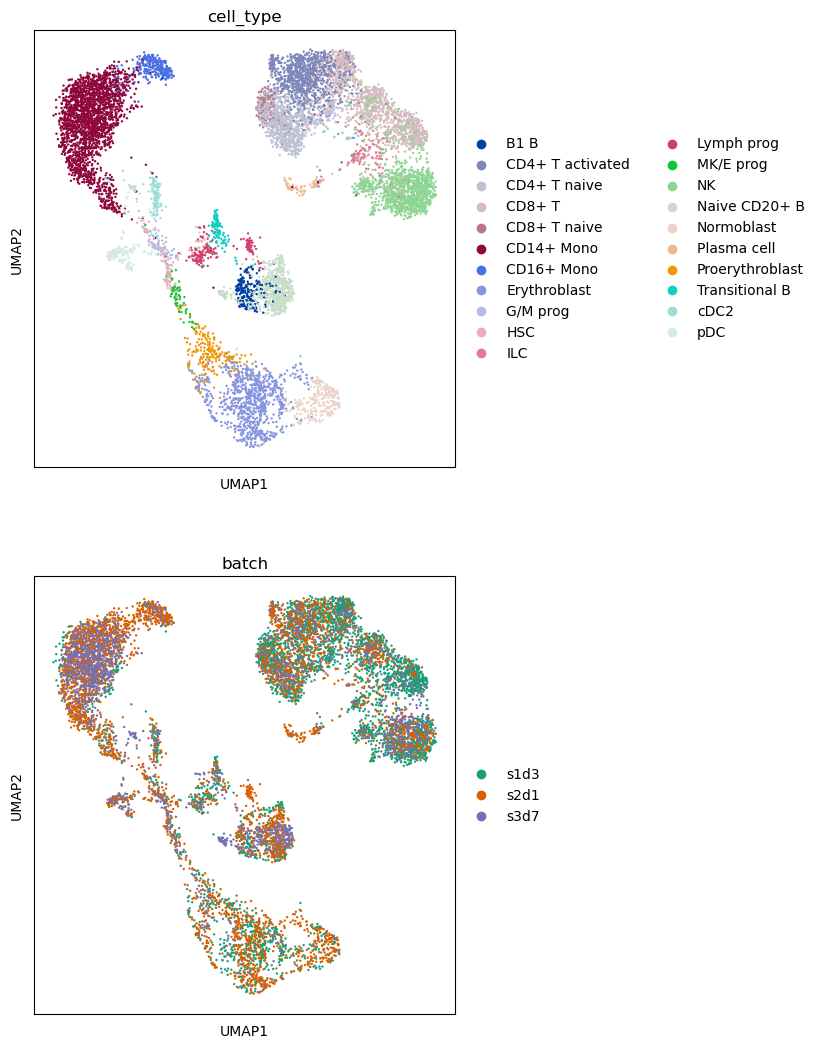

In [30]:
sc.pl.umap(adata, color=[label_key, batch_key], ncols=1)

In [31]:
# move harmony corrected umap
adata.obsm['X_umapharmony'] = adata.obsm['X_umap']

### 4. example: integration with bbknn

In [32]:
# run bbknn with scanpy external API
adata_bbknn = sc.external.pp.bbknn(adata, batch_key=batch_key, use_rep='X_pca', copy=True)

In [33]:
# since bbknn corrects the kNN graph, there will not be a new embedding
# rather, the obsp ['distances'] and obsp['connectivities'] are updated
adata_bbknn

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', 'harmony'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap', 'X_umapraw', 'X_pc

In [35]:
# to show that the new neighbors are actually different from the unintegrated neighbors
(adata.obsp['connectivities'] != adata_bbknn.obsp['connectivities']).sum()

292972

/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


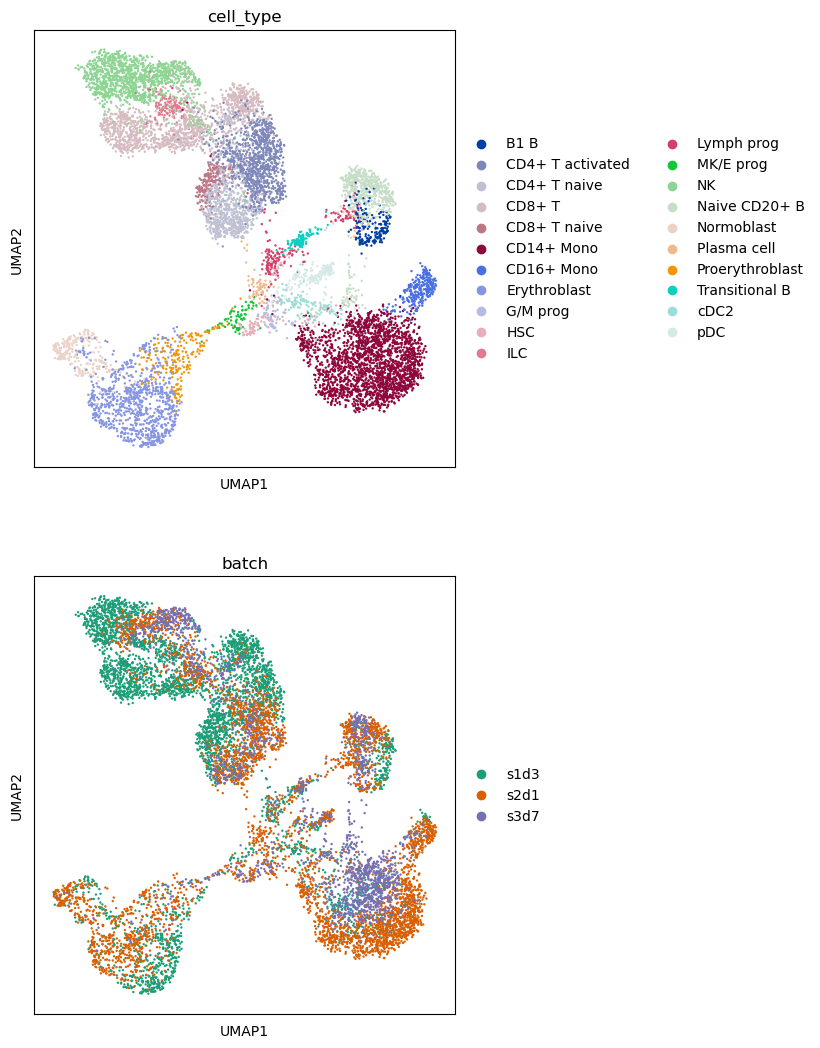

In [36]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], ncols=1)

### 5. example: integrate with mnnpy

In [37]:
# running mnnpy requires raw count data, and will return corrected counts (pseudo counts)
# so we first create another anndata for making the inputs

adata_new = adata.copy()

In [38]:
adata_new.X = adata_new.layers['counts'].copy()

In [39]:
# get all batches names

batches = adata_new.obs[batch_key].cat.categories.tolist()

In [40]:
batches

['s1d3', 's2d1', 's3d7']

In [41]:
# split the raw counts based on batch

adata_list = [ adata_new[adata_new.obs[batch_key] == batch].copy() for batch in batches]

In [42]:
# use batch-aware hvgs to aid MNN correction

hvg = adata.var.loc[adata.var.highly_variable].index.values

In [43]:
# run mnn_correct from mnnpy
# this takes ~2 mins

corrected = mnnpy.mnn_correct(adata_list[0], adata_list[1], adata_list[2], var_subset=hvg, batch_key=batch_key, batch_categories=batches, do_concatenate=True)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [45]:
# get corrected counts as a concatenated anndata file

adata_mnnpy = corrected[0]

In [46]:
# now analyse the corrected counts as they are log1p normalized counts

adata_mnnpy_hvg = adata_mnnpy[:, hvg]
sc.pp.scale(adata_mnnpy_hvg)
sc.pp.neighbors(adata_mnnpy_hvg)
sc.tl.umap(adata_mnnpy_hvg)

/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/training/miniconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


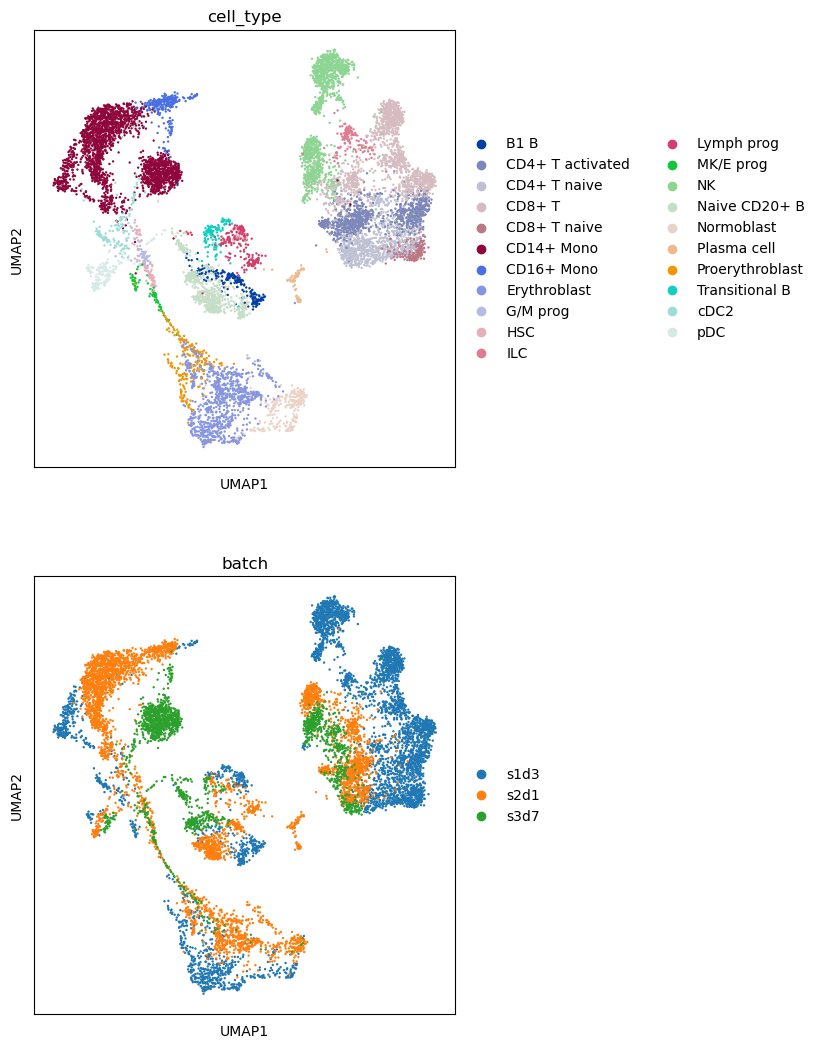

In [47]:
sc.pl.umap(adata_mnnpy_hvg, color=[label_key, batch_key], ncols=1)

### the end